In [6]:
!pip install pandas matplotlib fpdf2 numpy
!apt-get install -y fonts-dejavu
import pandas as pd
import matplotlib.pyplot as plt
from fpdf import FPDF
import numpy as np
from datetime import datetime, timedelta
import random


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra
The following NEW packages will be installed:
  fonts-dejavu fonts-dejavu-core fonts-dejavu-extra
0 upgraded, 3 newly installed, 0 to remove and 38 not upgraded.
Need to get 3,085 kB of archives.
After this operation, 10.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-extra all 2.37-2build1 [2,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-dejavu all 2.37-2build1 [3,192 B]
Fetched 3,085 kB in 1s (2,387 kB/s)
Selecting previously unselected package fonts-dejavu-core.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../fonts-dejavu-core_2.37-2build1_all.deb ...
Unpack

In [7]:
def generate_logs(num_entries=200):
    methods = ["GET", "POST", "PUT", "DELETE"]
    paths = [
        "/login", "/admin", "/profile", "/api/user",
        "/xss?payload=<script>alert(1)</script>",
        "/sqli?user=admin'--",
        "/idor?uid=42",
        "/flag", "/secret"
    ]
    status_codes = [200, 200, 404, 500, 403, 302]
    ips = [f"192.168.1.{i}" for i in range(1, 20)]

    logs = []
    for _ in range(num_entries):
        timestamp = (datetime.now() - timedelta(hours=random.randint(0, 6))).strftime("%d/%b/%Y:%H:%M:%S")
        ip = random.choice(ips)
        method = random.choice(methods)
        path = random.choice(paths)
        status = random.choice(status_codes)
        latency = random.randint(1, 500)
        logs.append(f'{ip} - - [{timestamp} +0000] "{method} {path} HTTP/1.1" {status} {latency}')
    return logs

# Générer et sauvegarder les logs
logs = generate_logs(200)
with open("logs.txt", "w") as f:
    f.write("\n".join(logs))
print("✅ 200 logs générés (exemple: /xss, /sqli, /idor).")


✅ 200 logs générés (exemple: /xss, /sqli, /idor).


In [8]:
# Lire les logs
with open("logs.txt", "r") as f:
    log_lines = f.readlines()

# Parser les logs (version adaptée à ton format)
data = []
for line in log_lines:
    line = line.strip()
    if not line:  # Ignorer les lignes vides
        continue

    try:
        # Séparer les parties de la ligne
        parts = line.split('"')
        if len(parts) < 2:
            print(f"⚠️ Format invalide: {line}")
            continue

        # Extraire la partie avant la requête (IP, timestamp)
        first_part = parts[0].strip().split()
        ip = first_part[0] if len(first_part) > 0 else "unknown"
        timestamp = first_part[3][1:] if len(first_part) > 3 else "unknown"  # Ex: "21/Oct/2025:07:39:29 +0000" → "21/Oct/2025:07:39:29"

        # Extraire la requête (GET /login HTTP/1.1)
        request = parts[1].strip()
        method_path_proto = request.split()
        method = method_path_proto[0] if len(method_path_proto) > 0 else "GET"
        path = method_path_proto[1] if len(method_path_proto) > 1 else "/"
        protocol = method_path_proto[2] if len(method_path_proto) > 2 else "HTTP/1.1"

        # Extraire le status et la latency
        last_part = parts[2].strip().split()
        status = int(last_part[0]) if len(last_part) > 0 else 200
        latency = last_part[1] if len(last_part) > 1 else "0"

        data.append([ip, timestamp, method, path, status, latency])

    except Exception as e:
        print(f"⚠️ Ligne ignorée: {line} (Erreur: {e})")
        continue

# Créer le DataFrame
if data:
    df = pd.DataFrame(data, columns=["IP", "Timestamp", "Method", "Path", "Status", "Latency"])
    df["Status Group"] = df["Status"].apply(lambda x: "2xx" if 200 <= x < 300 else "4xx/5xx" if x >= 400 else "3xx")

    # Définir les motifs d'attaques
    attack_patterns = {
        "XSS": r"<script|onerror|onload",
        "SQLi": r"'--|\bOR\b\s+1=1|\bUNION\b",
        "IDOR": r"uid=\d+|id=\d+|user_id=\d+",
        "Path Traversal": r"\.\./|\./",
    }

    # Détecter les attaques
    for attack, pattern in attack_patterns.items():
        df[f"Is_{attack}"] = df["Path"].str.contains(pattern, case=False, regex=True)

    print(f"✅ DataFrame créé avec {len(df)} entrées.")
    print("\n👀 Exemple de données:")
    display(df.head(3))
else:
    print("❌ Aucune donnée n'a pu être parsée. Vérifie le format de tes logs.")


✅ DataFrame créé avec 200 entrées.

👀 Exemple de données:


,IP,Timestamp,Method,Path,Status,Latency,Status Group,Is_XSS,Is_SQLi,Is_IDOR,Is_Path Traversal
0,192.168.1.11,21/Oct/2025:05:54:47,DELETE,/flag,403,299,4xx/5xx,False,False,False,False
1,192.168.1.14,21/Oct/2025:10:54:47,POST,/profile,302,277,3xx,False,False,False,False
2,192.168.1.18,21/Oct/2025:09:54:47,GET,/api/user,302,374,3xx,False,False,False,False


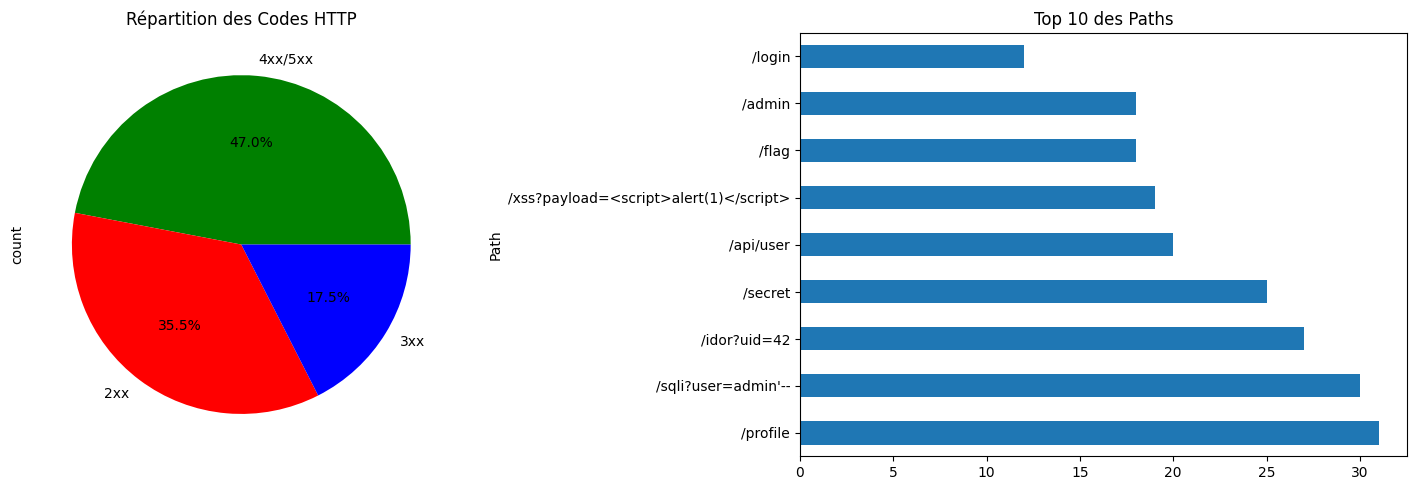


🚨 Attaques détectées:
- XSS: 19 occurrences (ex: /xss?payload=<script>alert(1)</script>)
- SQLi: 30 occurrences (ex: /sqli?user=admin'--)
- IDOR: 27 occurrences (ex: /idor?uid=42)


In [9]:
plt.figure(figsize=(15, 5))

# Répartition des codes HTTP
plt.subplot(1, 2, 1)
df["Status Group"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["green", "red", "blue"])
plt.title("Répartition des Codes HTTP")

# Top 10 des paths
plt.subplot(1, 2, 2)
df["Path"].value_counts().head(10).plot(kind="barh")
plt.title("Top 10 des Paths")

plt.tight_layout()
plt.show()

# Afficher les attaques détectées
print("\n🚨 Attaques détectées:")
for attack in attack_patterns.keys():
    count = df[f"Is_{attack}"].sum()
    if count > 0:
        print(f"- {attack}: {count} occurrences (ex: {df[df[f'Is_{attack}']]['Path'].iloc[0]})")


In [12]:
from fpdf import FPDF
from fpdf.enums import XPos, YPos
import os

# Créer le PDF
pdf = FPDF()

# Ajouter les polices DejaVu (sans le paramètre "uni" obsolète)
pdf.add_font('DejaVu', '', '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf')
pdf.add_font('DejaVu', 'B', '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf')
pdf.add_font('DejaVu', 'I', '/usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf')

# Configurer la police par défaut (UTF-8 est activé par défaut dans fpdf2)
pdf.set_font('DejaVu', size=12)
pdf.add_page()

# Titre
pdf.cell(0, 10, "Rapport d'Analyse des Logs – Audit de Sécurité", new_x=XPos.LMARGIN, new_y=YPos.NEXT, align="C")
pdf.ln(5)

# Stats générales
pdf.set_font('DejaVu', 'B', 12)
pdf.cell(0, 10, "Statistiques Générales:", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
pdf.set_font('DejaVu', size=12)
pdf.cell(0, 10, f"- Requêtes totales: {len(df)}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
pdf.cell(0, 10, f"- Erreurs (4xx/5xx): {len(df[df['Status Group'] == '4xx/5xx'])}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
pdf.cell(0, 10, f"- IPs uniques: {df['IP'].nunique()}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
pdf.ln(5)

# Attaques
pdf.set_font('DejaVu', 'B', 12)
pdf.cell(0, 10, "Attaques Détectées:", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
pdf.set_font('DejaVu', size=12)

attacks_found = False
for attack in attack_patterns.keys():
    count = df[f"Is_{attack}"].sum()
    if count > 0:
        attacks_found = True
        pdf.cell(0, 10, f"- {attack}: {count} occurrences", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        example = df[df[f"Is_{attack}"]]["Path"].iloc[0]
        pdf.cell(0, 10, f"  Exemple: {example[:50]}...", new_x=XPos.LMARGIN, new_y=YPos.NEXT)

if not attacks_found:
    pdf.cell(0, 10, "- Aucune attaque détectée.", new_x=XPos.LMARGIN, new_y=YPos.NEXT)

# Sauvegarder
os.makedirs("colab", exist_ok=True)
pdf.output("colab/rapport_audit.pdf")
print("\n✅ Rapport PDF généré : colab/rapport_audit.pdf")
print("📌 Télécharge-le depuis le panneau de gauche (Dossiers → colab/).")



✅ Rapport PDF généré : colab/rapport_audit.pdf
📌 Télécharge-le depuis le panneau de gauche (Dossiers → colab/).
